In [1]:
import os
import cv2
import argparse
import librosa
import numpy as np

import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils import data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import IPython.display as ipd

import easydict
from sklearn.model_selection import train_test_split
ALLMASKTYPES = ['time', 'bbox', 'freeform']


In [16]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_complex_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.amplitude_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
    
def plot_db_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [2]:

class InpaintDataset(Dataset):
    def __init__(self, opt, split):
        self.opt = opt
        self.split = split
        self.pow_to_db = torchaudio.transforms.AmplitudeToDB('power')
        self.get_list()
        
    def __getitem__(self, index):
        if self.split == 'TRAIN':
            if self.opt.mask_type == 'time':
                mask = self.time_mask()
            if self.opt.mask_type == 'bbox':
                mask = self.bbox2mask()
            if self.opt.mask_type == 'freeform':
                mask = self.random_ff_mask()
            audio = self.get_audio(index)
        elif self.split in ['VALID', 'TEST']:
            if self.opt.mask_type == 'time':
                masks_dir = '../split/fixedmask_time'
                mask = np.load(os.path.join(masks_dir, str(index)) + '.npy')
            if self.opt.mask_type == 'bbox':
                masks_dir = '../split/fixedmask_bbox'
                mask = np.load(os.path.join(masks_dir, str(index)) + '.npy')
            if self.opt.mask_type == 'freeform':
                masks_dir = '../split/fixedmask_freeform'
                mask = np.load(os.path.join(masks_dir, str(index)) + '.npy')
            audio = self.get_valid_audio(index)
        # spec = self.get_comlex_spectrogram(audio)
        spec = self.get_spectrogram(audio).unsqueeze(-1)
        spec = self.pow_to_db(spec)
        spec = spec.squeeze(0).permute(2, 0, 1).contiguous()
        mask = torch.from_numpy(mask.astype(np.float32)).contiguous()
        return audio, spec, mask

    
    def get_list(self):
        margs_trainvalid = np.loadtxt('../split/margs_trainvalid.txt', delimiter=',', dtype=str)
        margs_test = np.loadtxt('../split/margs_test.txt', delimiter=',', dtype=str)
        nuss_trainvalid = np.loadtxt('../split/nuss_trainvalid.txt', delimiter=',', dtype=str)
        nuss_test = np.loadtxt('../split/nuss_test.txt', delimiter=',', dtype=str)
        vocals_trainvalid = np.loadtxt('../split/vocals_trainvalid.txt', delimiter=',', dtype=str)
        vocals_test = np.loadtxt('../split/vocals_test.txt', delimiter=',', dtype=str)

        margs_train, margs_valid = train_test_split(margs_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        nuss_train, nuss_valid = train_test_split(nuss_trainvalid, test_size=0.1, shuffle=False, random_state=21)
        vocals_train, vocals_valid = train_test_split(vocals_trainvalid, test_size=0.1, shuffle=False, random_state=21)

        if self.split == 'TRAIN':
            train_list = self.dataset_merge(list(margs_train) + list(nuss_train) + list(vocals_train))
            self.fl = train_list
        elif self.split == 'VALID':
            valid_list = self.dataset_merge(list(margs_valid) + list(nuss_valid) + list(vocals_valid))
            self.fl = valid_list
        elif self.split == 'TEST':
            test_list = self.dataset_merge(list(margs_test) + list(nuss_test) + list(vocals_test))
            self.fl = test_list
    
    def dataset_merge(self, dataset):
        merged_dataset = []
        for ix, lis in enumerate(dataset):
            dat = torchaudio.info(os.path.join(self.opt.data_dir, lis))
            if dat.num_frames > 44100*2.5:
                merged_dataset.append(lis)
        return merged_dataset

    def get_audio(self, index):
        fn = self.fl[index]
        audio_path = os.path.join(self.opt.data_dir, fn)
        num_frames = torchaudio.info(audio_path).num_frames
        if num_frames <= self.opt.input_length:
            audio, sr = torchaudio.load(audio_path)
            audio = torch.nn.functional.pad(audio, (0, self.opt.input_length-num_frames), mode='constant', value=0)
        else:
            random_idx = np.random.randint(num_frames - self.opt.input_length)
            audio, sr = torchaudio.load(audio_path, frame_offset=random_idx, num_frames=self.opt.input_length)
        return audio

    def get_valid_audio(self, index):
        fn = self.fl[index]
        audio_path = os.path.join(self.opt.data_dir, fn)
        num_frames = torchaudio.info(audio_path).num_frames
        if num_frames <= self.opt.input_length:
            audio, sr = torchaudio.load(audio_path)
            audio = torch.nn.functional.pad(audio, (0, self.opt.input_length-num_frames), mode='constant', value=0)
        else:
            audio, sr = torchaudio.load(audio_path, frame_offset=0, num_frames=self.opt.input_length)
        return audio

    def get_comlex_spectrogram(self, waveform, n_fft = 2048, win_len = 2048, hop_len = 512, power=None):
        spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
        return_complex=0,
        )
        return spectrogram(waveform)

    def get_spectrogram(self, waveform, n_fft = 2048, win_len = 2048, hop_len = 512, power=2):
        spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
        )
        return spectrogram(waveform)

    def random_bbox(self):
        max_freq_ix = self.opt.image_height - self.opt.bbox_shape
        max_frame_ix = self.opt.image_width - self.opt.bbox_shape

        box_freq_ix = np.random.randint(max_freq_ix)
        box_frame_ix = np.random.randint(max_frame_ix)

        return (box_freq_ix, box_frame_ix, self.opt.bbox_shape, self.opt.bbox_shape)

    def time_mask(self):
        mask_width = np.random.randint(low=8, high=87)
        max_frame_ix = self.opt.image_width - mask_width
        t = np.random.randint(max_frame_ix)
        mask = np.zeros((self.opt.image_height, self.opt.image_width))
        mask[:,t:t+mask_width] = 1
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def bbox2mask(self):
        bboxs = []
        times = np.random.randint(8)
        for i in range(times):
            bbox = self.random_bbox()
            bboxs.append(bbox)
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        for bbox in bboxs:
            h = int(bbox[2] * 0.1) + np.random.randint(int(bbox[2] * 0.2 + 1))
            w = int(bbox[3] * 0.1) + np.random.randint(int(bbox[3] * 0.2) + 1)
            mask[(bbox[0] + h) : (bbox[0] + bbox[2] - h), (bbox[1] + w) : (bbox[1] + bbox[3] - w)] = 1.
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def random_ff_mask(self):
        """Generate a random free form mask with configuration.
        Args:
            config: Config should have configuration including IMG_SHAPES,
                VERTICAL_MARGIN, HEIGHT, HORIZONTAL_MARGIN, WIDTH.
        Returns:
            tuple: (top, left, height, width)
        """
        mask = np.zeros((self.opt.image_height, self.opt.image_width), np.float32)
        max_angle = 4
        max_len = 200
        max_width = 20
        times = np.random.randint(7)
        for i in range(times):
            start_x = np.random.randint(self.opt.image_width)
            start_y = np.random.randint(self.opt.image_height)
            for j in range(1 + np.random.randint(5)):
                angle = 0.01 + np.random.randint(max_angle)
                if i % 2 == 0:
                    angle = 2 * 3.1415926 - angle
                length = 10 + np.random.randint(max_len)
                brush_w = 5 + np.random.randint(max_width)
                end_x = (start_x + length * np.sin(angle)).astype(np.int32)
                end_y = (start_y + length * np.cos(angle)).astype(np.int32)
                cv2.line(mask, (start_y, start_x), (end_y, end_x), 1.0, brush_w)
                start_x, start_y = end_x, end_y
        return mask.reshape((1, ) + mask.shape).astype(np.float32)

    def __len__(self):
        return len(self.fl)

In [3]:
opt = easydict.EasyDict({
    "data_dir": '/data1/singing_inpainting/dataset',
    "input_length": 220500,
    "image_height": 1025,
    "image_width": 431,
    "bbox_shape": 120,
    "num_workers": 4,
    "mask_type": 'time',
    "batch_size": 4,
    })

In [4]:
trainset = InpaintDataset(opt, split='TRAIN')
print('The overall number of images equals to %d' % len(trainset))

# Define the dataloader
dataloader = DataLoader(trainset, batch_size = opt.batch_size, shuffle = True, num_workers = opt.num_workers, pin_memory = True)


The overall number of images equals to 6605


In [5]:
audio, img, mask = trainset[0][0], trainset[0][1], trainset[0][2]
print(audio.shape, img.shape, mask.shape)

torch.Size([1, 220500]) torch.Size([1, 1025, 431]) torch.Size([1, 1025, 431])


In [6]:
ipd.Audio(audio, rate=44100)

In [7]:
spec1 = InpaintDataset.get_spectrogram(_, audio)

In [20]:
None != True

True

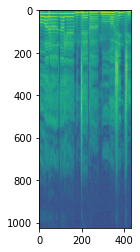

In [15]:
plt.imshow(img[0])

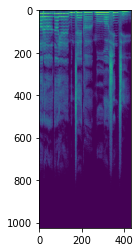

In [14]:
plt.imshow(librosa.power_to_db(spec1[0]))

In [72]:
energy_difference(spec1, spec2.squeeze(-1))

-0.22586271166801453

In [105]:
pow_to_db = torchaudio.transforms.AmplitudeToDB('power')

In [117]:
torch.audio

torch.Size([1, 1025, 431])

In [146]:
ones = torch.ones([1, 100]) * 100
pow_ = pow_to_db(ones)
pow_

tensor([[20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20.]])

In [148]:
librosa.db_to_amplitude(pow_)

tensor([[100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100.]])

In [140]:
start = time.time()

for i in range(100):
    librosa.power_to_db(0+np.e**(-4))

print(time.time()-start)



0.007340669631958008


In [142]:
start = time.time()

for i in range(100):
    librosa.power_to_db(0)

print(time.time()-start)



0.00743556022644043


In [101]:
pow_to_db(zeros)

tensor([[40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
         40., 40.]])

In [86]:
zeros

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [48]:
def mag(S):
    real = S[...,:1]
    imag = S[...,1:]
    m = real**2 + imag**2
    m = torch.sqrt(m+1e-5)
    return m

In [49]:
spec3 = mag(spec)

In [69]:
spec2[0][...,:1].shape

torch.Size([1025, 431, 1])

In [57]:
real = spec2[...,:1]
imag = spec2[...,1:]

In [60]:
m = real**2 + imag**2
m = torch.sqrt(m+1e-5)


In [61]:
m.shape

torch.Size([1, 1025, 431, 1])